<a href="https://colab.research.google.com/github/Mr-Moore/machine-learning/blob/main/03b_finetune_MOBILENETV2_flower5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install git+https://github.com/OverLordGoldDragon/keras-adamw

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/OverLordGoldDragon/keras-adamw to /tmp/pip-req-build-x56eih2t
  Running command git clone --filter=blob:none --quiet https://github.com/OverLordGoldDragon/keras-adamw /tmp/pip-req-build-x56eih2t
  Resolved https://github.com/OverLordGoldDragon/keras-adamw to commit 017d3e8ac6eadd40306710bd42aad7328af5083f
  Preparing metadata (setup.py) ... done
  Created wheel for keras-adamw: filename=keras_adamw-1.38-py3-none-any.whl size=29523 sha256=0492be6450eab4d47b8147b0ad9f4b0d606810315678f519c848573014908af2
  Stored in directory: /tmp/pip-ephem-wheel-cache-7e4czc5d/wheels/68/3c/a5/46d0eac3ed4d5ce267aea0b79f5e5bcc3d2c525092f78f64d0
Successfully built keras-adamw


In [ ]:
pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 15.9 MB/s eta 0:00:00


In [ ]:
import IPython

IPython.Application.instance().kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

In [ ]:
import math, re, os, sys
import tensorflow as tf
# import tensorflow_addons as tfa
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
print("Tensorflow version" + tf.__version__)
AUTO = tf.data.experimental.AUTOTUNE

Tensorflow version2.12.0


In [ ]:
# Warning! This call has to come before *any* Tensorflow calls.
# If you get errors about Adamw not being found, restart the kernal and start from previous cell.
# 通過os.environ獲取、設置、刪除環境變數，什麼是環境變數呢？ 環境變數是程式和作業系統之間的通信方式。

os.environ['TF_KERAS'] = '1'
from keras_adamw import AdamW

ModuleNotFoundError: ignored

In [ ]:
'''tf.distribute.MirroredStrategy supports synchronous distributed training on multiple GPUs on one machine.
    It creates one replica per GPU device. Each variable in the model is mirrored across all the replicas. '''

'''ClusterResolvers are a way for TensorFlow to communicate with various cluster management systems
 (e.g. GCE, AWS, etc...) and gives TensorFlow necessary information to set up distributed training(分散式訓練)'''

# tf.distribute.TPUStrategy Synchronous training on TPUs and TPU Pods.
# 張量處理單元（英文：Tensor Processing Unit，簡稱：TPU）專門用於加速機器學習.
# https://www.tensorflow.org/api_docs/python/tf/distribute/cluster_resolver/TPUClusterResolver

try: # detect TPUs
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
  strategy = tf.distribute.TPUStrategy(tpu)
except ValueError: # detcet GPUs or multi-GPU machines
  strategy = tf.distribute.MirroredStrategy()

print("REPLCAS: ", strategy.num_replicas_in_sync)

REPLCAS:  1


Learning rate schedule: 1e-05 to 0.0001 to 2.21e-05


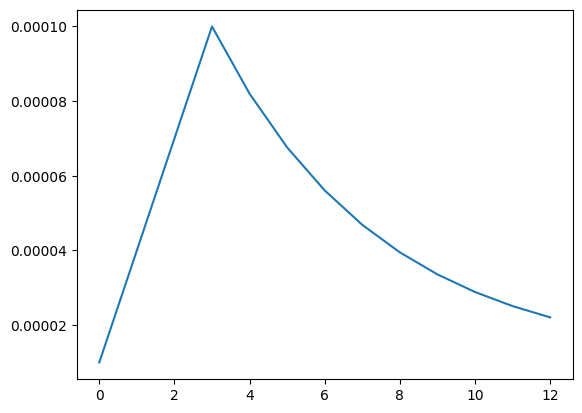

In [ ]:
GCS_DS_PATH = "gs://practical-ml-vision-book/flowers_5_tfr"

# Settings for TPUv3. When running on hardware with less memory such as a TPUv2 (Colab)
# or a GPU, you might have to use lower BATCH_SIZE and/or IMAGE_SIZE values.

IMAGE_SIZE = [224, 224] # available image size in flowers104 dataset: 512x512, 331x331, 224x224, 192x192
EPOCHS = 13

'''Traditional learning rate schedule don't have warm-up ramp'''

''' Why do BATCH_SIZE = 16 * strategy_num_replicas_in_sync?
This needs to be done because after the gradients are calculated on each replica,
they are synced across the replicas by summing them to calculate loss.
Additional: https://www.tensorflow.org/tutorials/distribute/custom_training#define_the_loss_function '''

# Learning rate schedule for "fine-tuning": use trainable=True (best validation accuracy 0.91)
#RAMPUP 預熱斜坡 DECAY 下降曲線率
#BATCH_SIZE = 16 * strategy_num_replicas_in_sync
#LR_START = 0.00001
#LR_MAX = 0.000025 * strategy_num_replicas_in_sync
#LR_MIN = 0.00001
#LR_RAMPUP_EPOCHS = 3
#LR_SUSTAIN_EPOCHS = 1
#LR_EXP_DECAY = .8

# Learning rate schedule for "fine-tuning with Adamw": use trainable=True (best validation accuracy 0.92)
BATCH_SIZE = 8 * strategy.num_replicas_in_sync
LR_START = 0.00001
LR_MAX = 0.0001 * strategy.num_replicas_in_sync
LR_MIN = 0.00001
LR_RAMPUP_EPOCHS = 3
LR_SUSTAIN_EPOCHS = 0
LR_EXP_DECAY = .8

# Learning rate schedule for "transfer learning": use trainable=False (best validation accuracy 0.90)
#BATCH_SIZE = 16 * strategy_num_replicas_in_sync
#LR_START = 0.00001
#LR_MAX = 0.00075 * strategy_num_replicas_in_sync #(Note: 0.00007 with trainable=True to replicate graph in book)
#LR_MIN = 0.00001
#LR_RAMPUP_EPOCHS = 0
#LR_SUSTAIN_EPOCHS = 0
#LR_EXP_DECAY = .8


GCS_PATH_SELECT = { # available image sizes
    192: GCS_DS_PATH + '/tfrecords-jpeg-192x192',
    224: GCS_DS_PATH + '/tfrecords-jpeg-224x224',
    331: GCS_DS_PATH + '/tfrecords-jpeg-331x331',
    512: GCS_DS_PATH + '/tfrecords-jpeg-512x512'
}
GCS_PATH = GCS_PATH_SELECT[IMAGE_SIZE[0]] + '/*.tfrec'
# Returns a list of files that match the given pattern(s).
filenames = tf.io.gfile.glob(GCS_PATH)
validation_split = 0.19
split = len(filenames) - int(len(filenames) * validation_split)
TRAINING_FILENAMES = filenames[:split]
VALIDATION_FILENAMES = filenames[split:]

CLASSES = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

def lrfn(epoch):
  if epoch < LR_RAMPUP_EPOCHS:
    lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
  elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
    lr = LR_MAX
  else:
    lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
  return lr

# tf.keras.callbacks.LearningRateScheduler(schedule, verbose=0) (Learning rate scheduler(學習率行程調度器))
lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=True)

rng = [i for i in range(EPOCHS)]
y = [lrfn(x) for x in rng]
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

In [ ]:
# numpy and matplotlib defaults
'''Set printing options.
These options determine the way floating point numbers, arrays and other NumPy objects are displayed.
https://numpy.org/doc/stable/reference/generated/numpy.set_printoptions.html '''
np.set_printoptions(threshold=15, linewidth=80)

def batch_to_numpy_images_and_labels(data):
  images, labels = data
  numpy_images = images.numpy()
  numpy_labels = labels.numpy()
  # expect int, str...... will be map to object
  if numpy_labels.dtype == object: # binary string in this case, these are image ID strings
    numpy_labels = [None for _ in enumerate(numpy_images)] # [None, None, None....]
  # If no labels, only image IDs, return 'None' for labels (this is the case for test data)
  return numpy_images, numpy_labels

def title_from_label_and_target(label, correct_label):
  if correct_label is None:
    return CLASSES[label], True
  correct = (label == correct_label)
  # \u2192: RIGHTWARDS ARROW
  return "{} [{}{}{}]".format(CLASSES[label], 'OK' if correct else 'NO', u"\u2192" if not correct else '',
                 CLASSES[correct_label] if not correct else ''), correct

# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplot.html
# plt.subplot(221)
# equivalent but more general
# ax1 = plt.subplot(2, 2, 1), pad(default=6.0)
def display_one_flower(image, title, subplot, red=False, titlesize=16):
  plt.subplot(*subplot)
  plt.axis('off')
  plt.imshow(image)
  if len(title) > 0:
    plt.title(title, fontsize=int(titlesize) if not red else int(titlesize/1.2), color='red' if red else 'black', fontdict={'verticalalignment':'center'}, pad=int(titlesize/1.5))
  return(subplot[0], subplot[1], subplot[2]+1)

def display_batch_of_images(databatch, predictions=None):
  """This will work with
  display_batch_of_images(images)
  display_batch_of_images(images, predictions)
  display_batch_of_images((images, labels))
  display_batch_of_images((images, labels), predictions)
  """
  # data
  images, labels = batch_to_numpy_images_and_labels(databatch)
  if labels is None:
    labels = [None for _ in enumerate(images)]

  # auto-squaring: this will drop data that doesn't fit into square or square-ish rectangle
  rows = int(math.sqrt(len(images)))
  cols = len(images)//rows

  '''NEED TEST'''
  # size and spacing
  FIGSIZE = 13.0
  SPACING = 0.1
  subplot = (rows, cols, 1)
  if rows < cols:
    plt.figure(figsize=(FIGSIZE, FIGSIZE/rows*cols))
  else:
    plt.figure(figsize=(FIGSIZE/rows*cols, FIGSIZE))

  # display
  # use zip to map values ex.[(images[0], labels[0]), ....]. It is a iterable object.
  for i, (image, label) in enumerate(zip(images[:rows*cols], labels[:rows*cols])):
    title = '' if label is None else CLASSES[label]
    correct = True
    if predictions is not None:
      title, correct = title_from_label_and_target(predictions[i], label)
    dynamic_titlesize = FIGSIZE*SPACING/max(rows,cols)*40+3 # magic formula tested to work from 1x1 to 10x10 images
    subplot = display_one_flower(image, title, subplot, not correct, titlesize=dynamic_titlesize)

  # layout
  # https://matplotlib.org/stable/tutorials/intermediate/tight_layout_guide.html automatic adjust subplot padding
  # subplot_adjust: Adjust the subplot layout parameters.
  # https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplots_adjust.html
  plt.tight_layout()
  if label is None and predictions is None:
    plt.subplots_adjust(wspace=0, hspace=0)
  else:
    plt.subplots_adjust(wspace=1, hspace=1)
  plt.show()

def display_confusion_matrix(cmat, score, precision, recall):
  # plt.figsize(figsize=(15,15))
  # Get the current Axes.
  ax = plt.gca()
  # Plot the values of a 2D matrix or array as color-coded image.
  # cmap参数接受一个值（每个值代表一种配色方案），并将该值对应的颜色图分配给当前图窗。
  ax.matshow(cmat, cmap='Reds')
  # Set the xaxis' tick locations and optionally labels.
  ax.set_xticks(range(len(CLASSES)))
  ax.set_xtickslabels(CLASSES)
  # If "anchor", then alignment occurs before rotation.
  # https://matplotlib.org/stable/api/text_api.html#matplotlib.text.Text.set_rotation_mode
  # https://matplotlib.org/stable/gallery/text_labels_and_annotations/demo_text_rotation_mode.html
  plt.setp(ax.get_xticklabels(), rotation=45, ha="left", rotation_mode="anchor")
  ax.set_yticks(range(len(CLASSES)))
  ax.set_ylabels(CLASSES)
  plt.setp(ax.get_yticklabels(), rotation=45, ha="right", rotation_mode="anchor")
  # titlestring = ""
  # if score is not None:
  #   titlestring += 'f1 = {:.3f} '.format(score)
  # if precision is not None:
  #   titlestring += '\nprecision = {:.3f} '.format(precision)
  # if recall is not None:
  #   titlestring += '\nrecall = {:.3f} '.format(recall)
  # # ax.text(x, y, s), x = x position, y = y position.
  # if len(titlestring) > 0:
  #   ax.text(101, 1, titlestring, fontdict={'fontsize' : 18, 'horizontalalignment' : 'right', 'verticalalignment' : 'top', 'color' : '#804040'})
  plt.show()

# https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.legend.html
def display_training_curves(training, validation, title, subplot, zoom_pcent=None, ylim=None):
  # zoom_pcent: X autoscales y axis for the last X% of data points
  if subplot%10==1: # set up the subplots on the first call
    plt.subplots(figsize=(10,10), facecolor='#F0F0F0') # facecolor define background color
    plt.tight_layout()
  ax = plt.subplot(subplot)
  ax.set_facecolor('F8F8F8')
  ax.plot(training)
  ax.plot(validation, '--')
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  if zoom_pcent is not None:
    ylen = len(training) * (100 - zoom_pcent) // 100
    ymin = min([min(training[ylen:]), min(validation[ylen:])])
    ymax = max([max(training[ylen:]), max(validation[ylen:])])
    ax.set_ylim([ymin - (ymax-ymin) / 20, ymax + (ymax-ymin) / 20])
  if ylim is not None:
    ymin = ylim[0]
    ymax = ylim[1]
    ax.set_ylim([ymin - (ymax-ymin) / 20, ymax + (ymax-ymin) / 20])
  ax.set_xlabel('epoch')
  ax.legend(['train', 'valid.'])

In [ ]:
# channels: An optional int. Defaults to 0. Number of color channels for the decoded image.
def decode_image(image_data):
  image = tf.image.decode_jpeg(image_data, channels=3)# decoded image in unit8 format range[0, 255]
  image = tf.reshape(image, [*IMAGE_SIZE, 3])
  return image

# tf.io.FixedLenFeature: Configuration for parsing a fixed-length input feature.
# bytestring: which doesn't know if it's text or images or any other kind of data.
def read_tfrecord(example):
  TFREC_FORMAT = {
    "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
    "class": tf.io.FixedLenFeature([], tf.int64) # shape [] means single element
  }
  example = tf.io.parse_single_example(example, TFREC_FORMAT)
  image = decode_image(example['image'])
  label = tf.cast(example['class'], tf.int32) # tf.cast: Casts a tensor to a new type.
  return image, label # returns a dataset of (image, label) pairs

# 使用 tf.data.Dataset.map 方法可将函数应用于 Dataset 的每个元素。
# The options can be set by constructing an Options object and using the
# tf.data.Dataset.with_options(options) transformation, which returns a dataset with the options set.
def load_dataset(filenames, ordered=False):
  # Read from TFRecords. For optimal performance, reading from multiple files at once and
  # disregarding data order. Order does not matter since we will be shuffling the data anyway.

  ignore_order = tf.data.Options()
  if not ordered:
    ignore_order.deterministic = False # disable order, increase speed

  dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO) # automatically interleaves(交織) reads from multiple files
  dataset = dataset.with_options(ignore_order) # uses data as soon as it streams(流) in, rather than in its original order.
  dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTO)
  # return a dataset of (image, label) pairs
  return dataset

# Data augmentation is a set of techniques to artificially increase the amount of data by generating new data points from existing data.
# This includes making small changes to data or using deep learning models to generate new data points.
def data_augment(image, label):
  # data augmentation. Thanks to the dataset.prefetch(AUTO) statement in the next funtion (below),
  # this happens essentially for free on TPU. Data pipeline code is excuted on the "CPU" part
  # of the TPU while the TPU itself is computing gradients(梯度).
  image = tf.image.random_flip_left_right(image)
  #image = tf.image.random_saturation(image, 0, 2)
  return image, label

def get_training_dataset():
  dataset = load_dataset(TRAINING_FILENAMES)
  dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
  # the training dataset must repeat for several epochs, 当repeat()参数为空时，意思是重复无数遍，永远不会有读取不到数据batch的情况。
  # if epochs not finish yet repeat(x) times already finish will cause error.
  dataset = dataset.repeat()
  # This dataset fills a buffer with buffer_size elements, then randomly
  # samples elements from this buffer, replacing the selected elements with new elements.
  # 隨機打亂這個數據集的元素。
  # 該數據集用buffer_size 元素填充緩衝區，然後從該緩衝區中隨機采樣元素，用新元素替換所選元素。對於完美的混洗，需要大於或等於數據集完整大小的緩衝區大小。
  dataset = dataset.shuffle(2048)
  dataset = dataset.batch(BATCH_SIZE)
  dataset = dataset.prefetch(AUTO) # prefetch(buffer_size): prefetch next batch while training (autotune prefetch buffer size)
  return dataset

def get_validation_dataset(ordered=False):
  dataset = load_dataset(VALIDATION_FILENAMES, ordered=ordered)
  dataset = dataset.batch(BATCH_SIZE)
  # dataset.cache(): 第一次迭代数据集时，其元素将缓存在指定文件或内存 后续迭代将使用缓存数据
  # 迭代器对象从集合的第一个元素开始访问，直到所有的元素被访问完结束。迭代器只能往前不会后退。
  dataset = dataset.cache()
  dataset = dataset.prefetch(AUTO)
  return dataset

def count_data_items(filenames):
  # the number of data items is written in the name of the .tfrec files, i.e. flowers00-230.tfrec = 230 data items
  n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
  return np.sum(n)

# steps_per_epoch: 用于指定每个epoch所使用的迭代次数
NUM_TRAINING_IMAGES = count_data_items(TRAINING_FILENAMES)
NUM_VALIDATION_IMAGES = count_data_items(VALIDATION_FILENAMES)
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE
VALIDATION_STEPS = -(-NUM_VALIDATION_IMAGES // BATCH_SIZE) # The "-(-//)" trick rounds up instead of down :-)
print('Dataset: {} training images, {} validation images'.format(NUM_TRAINING_IMAGES, NUM_VALIDATION_IMAGES))

Dataset: 2990 training images, 680 validation images


In [ ]:
# data dump
print("Training data shapes:")
for image, label in get_training_dataset().take(3):
  print(image.numpy().shape, label.numpy().shape)
print("Training data label examples:", label.numpy())

Training data shapes:
(8, 224, 224, 3) (8,)
(8, 224, 224, 3) (8,)
(8, 224, 224, 3) (8,)
Training data label examples: [3 4 3 4 0 0 3 0]


In [ ]:
# Peek at training data
training_dataset = get_training_dataset()
training_dataset = training_dataset.unbatch().batch(20)
train_batch = iter(training_dataset)

In [ ]:
# run this cell again for next set of images
display_batch_of_images(next(train_batch))

In [ ]:
# 首先，在该策略的作用域内创建模型和优化器。这样可以确保使用模型和优化器创建的任何变量都是镜像变量。
# 将 Keras 模型、优化器和指标的创建移到 strategy.scope 中。模型的 call()、train_step() 和 test_step() 方法中的代码都将在加速器上分布和执行。

# weights: String, one of None (random initialization), 'imagenet' (pre-training on ImageNet), or the path to the weights file to be loaded.
# include_top: Boolean, whether to include the fully-connected layer at the top of the network. Defaults to True.
with strategy.scope():
  pretrained_model = tf.keras.applications.MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=[*IMAGE_SIZE, 3])

  pretrained_model.trainable = True # fine-tuning

  #tf.keras.layers.GlobalAveragePooling2D(): 将特征转换成每个图像一个向量
  model = tf.keras.Sequential([
    # tf.keras.layers.Lambda: Wraps arbitrary expressions as a Layer object.
    tf.keras.layers.Lambda( # convert image format from int [0,255] to the format expected by this model
      # https://www.tensorflow.org/api_docs/python/tf/keras/applications/mobilenet/preprocess_input
      lambda data: tf.keras.applications.mobilenet.preprocess_input(
          tf.cast(data, tf.float32)), input_shape=[*IMAGE_SIZE, 3]),
    pretrained_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(16, activation='relu', name='flower_dense'),
    tf.keras.layers.Dense(len(CLASSES), activation='softmax', name='flower_prob')
  ])

  # https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules/PiecewiseConstantDecay
  mult = 0.4 # for pretrained layers
  step = tf.Variable(0, trainable=False)
  boundaries = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
  values = [0.008, 0.016, 0.024, 0.032, 0.04, 0.06, 0.08, 0.1, 0.12, 0.14, 0.16, 0.2, 0.24, 0.28, 0.32, 0.36, 1]
  schedule = tf.optimizers.schedules.PiecewiseConstantDecay(boundaries, values)
  wd = schedule(step)
  # mult_by_layer={
  #   'flower_prob': 1.0,
  #   'flower_dense': 1.0,
  #   'block_1_': 0.02 * mult,
  #   'block_2_': 0.04 * mult,
  #   'block_3_': 0.06 * mult,
  #   'block_4_': 0.08 * mult,
  #   'block_5_': 0.1 * mult,
  #   'block_6_': 0.15 * mult,
  #   'block_7_': 0.2 * mult,
  #   'block_8_': 0.25 * mult,
  #   'block_9_': 0.3 * mult,
  #   'block_10_': 0.35 * mult,
  #   'block_11_': 0.4 * mult,
  #   'block_12_': 0.5 * mult,
  #   'block_13_': 0.6 * mult,
  #   'block_14_': 0.7 * mult,
  #   'block_15_': 0.8 * mult,
  #   'block_16_': 0.9 * mult,
  #   'conv': 0.5 * mult,
  #   'Conv': 0.5 * mult
  # }

  optimizer2 = tfa.optimizers.AdamW(learning_rate=LR_MAX, weight_decay=wd)

# https://keras.io/api/models/model_training_apis/
# step_per_excution: The number of batches to run during each tf.function call.
model.compile(
  #optimizer='adam'
  optimizer = optimizer2,
  loss = 'sparse_categorical_crossentropy',
  metrics=['sparse_categorical_accuracy'],
  steps_per_execution=8
)
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_3 (Lambda)           (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_3   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 flower_dense (Dense)        (None, 16)                20496     
                                                                 
 flower_prob (Dense)         (None, 5)                 85        
                                                                 
Total params: 2,278,565
Trainable params: 2,244,453
No

In [ ]:
# callbacks can use self-define function. ps.P65
# Use lower LR to pretrained layers.
history = model.fit(get_training_dataset(), steps_per_epoch=STEPS_PER_EPOCH, epochs=EPOCHS,
           validation_data=get_validation_dataset(), validation_steps=VALIDATION_STEPS,
           callbacks=[lr_callback])

In [ ]:
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 211, ylim=[0,1.7])
display_training_curves(history.history['sparse_categorical_accuracy'], history.history['val_sparse_categorical_accuracy'], 'accuracy', 212)

In [ ]:
cmdataset = get_validation_dataset(ordered=True) # since we are splitting the dataset and iterating separately on images and labels, order matters.
# map(lambda parameter: expression, iterable) ex. map(lambda x: x+1, list())
images_ds = cmdataset.map(lambda image, label: image)
labels_ds = cmdataset.map(lambda image, label: label).unbatch()
cm_correct_labels = next(iter(labels_ds.batch(NUM_VALIDATION_IMAGES))).numpy() # get everything as one batch
cm_probabilities = model.predict(images_ds, steps=VALIDATION_STEPS)
cm_predictions = np.argmax(cm_probabilities, axis=-1)
# cm_probabilities.shape = (all validation images, 5)
print("Correct labels: ", cm_correct_labels.shape, cm_correct_labels)
print("Predicted labels: ", cm_predictions.shape, cm_predictions)

In [ ]:
cmat = confusion_matrix(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)))
# macro: Calculate metrics for each label, and find their unweighted mean.
# In the multi-class and multi-label case, this is the average of the F1 score of each class with weighting(重要性，分量) depending on the average parameter.
score = f1_score(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)), average='macro')
# The precision is intuitively the ability of the classifier not to label as positive a sample that is negative. tp / (tp + fp)
precision = precision_score(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)), average='macro')
# The recall is intuitively the ability of the classifier to find all the positive samples. tp / (tp + fn), fn ex. corr: 0, pred: 1.
recall = recall_score(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)), average='macro')
# .T: transpose matrix
cmat = (cmat.T / cmat.sum(axis=1)).T # normalized
cmat = display_confusion_matrix(cmat, score, precision, recall)
print('f1 score: {:.3f}, precision: {:.3f}, recall: {:.3f}'.format(score, precision, recall))

In [ ]:
# rebatch(N) is functionally equivalent to unbatch().batch(N), but is more efficient, performing one copy instead of two.
dataset = get_validation_dataset()
dataset = dataset.rebatch(20)
batch = iter(dataset)

In [ ]:
# run this cell again for next set image
# 可以理解为 axis=-1 结果与 axis=（维度-1） 一致
# if a array 2x3, axis=0 output (3,), axis=1 output (2,).
images, labels = next(batch)
probabilities = model.predict(images)
# test probabilities array shape
print(np.shape(probabilities))
predictions = np.argmax(probabilities, axis=-1)
display_batch_of_images((images, labels), predictions)

In [ ]:
# figsize example
plt.figure(figsize=(1, 1))
plt.plot()

In [ ]:
def tr_argument(o=True):
  print(o)

i = tr_argument(not True)

False


In [ ]:
a = np.arange(6).reshape(2,3) + 10
print("{}, {}, {}, {}".format(a, np.argmax(a), np.argmax(a, axis=0), np.argmax(a, axis=-1)))

[[10 11 12]
 [13 14 15]], 5, [1 1 1], [2 2]


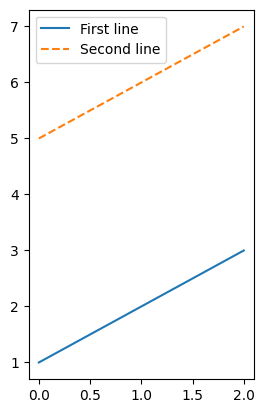

In [ ]:
ax = plt.subplot(121)
ax.plot([1, 2, 3])
ax.plot([5, 6, 7], '--')
# Discouraged This call signature is discouraged, because the relation between
# plot elements and labels is only implicit by their order and can easily be mixed up.
ax.legend(['First line', 'Second line'])

In [ ]:
a =[1, 2]
b = [3, 4]
c = (a, b)
d = map(lambda a, b: b, a, b)
print(a, list(d))

[1, 2] [3, 4]


In [ ]:
y_true = [2, 1, 4, 1, 2, 0, 3]
y_pred = [2, 0, 0, 1, 2, 1, 4]
cmat = confusion_matrix(y_true, y_pred, labels=[0,1,2,3,4])
print(cmat)

[[0 1 0 0 0]
 [1 1 0 0 0]
 [0 0 2 0 0]
 [0 0 0 0 1]
 [1 0 0 0 0]]


In [ ]:
# precision_score example
y_true = [0, 1, 2, 0, 1, 2]
y_pred = [0, 2, 1, 0, 0, 1]
precision_score(y_true, y_pred, average='macro')
precision_score(y_true, y_pred, average=None)
y_pred = [0, 0, 0, 0, 0, 0]
precision_score(y_true, y_pred, average=None, zero_division=0)

array([0.33333333, 0.        , 0.        ])

In [ ]:
# recall_score example
from sklearn.metrics import recall_score
y_true = [0, 1, 2, 0, 1, 2]
y_pred = [0, 2, 1, 0, 0, 1]
recall_score(y_true, y_pred, average='macro',zero_division=0)
recall_score(y_true, y_pred, average=None, zero_division=0)
y_true = [0, 0, 0, 0, 0, 0]
recall_score(y_true, y_pred, average=None, zero_division=0)

array([0.5, 0. , 0. ])

In [ ]:
# tf.saved_model.SaveOptions: Options for saving to SavedModel.
# experimental_io_device: Tensorflow device to use to access the filesystem.
# TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:1 with 15128 MB memory)
# https://medium.com/@dlspm/%E5%AE%89%E8%A3%9D-tensorflow-cuda-cudnn-%E5%B0%8D%E6%87%89%E7%89%88%E6%9C%AC-182006aa9768

In [ ]:
validation_dataset = get_validation_dataset(ordered=True)

def load_model_and_predict_logits(model_name, dataset):
  print("Loading model", model_name)
  with strategy.scope():
    load_locally = tf.saved_model.LoadOptions(experimental_io_device='/job:localhost')
    model = tf.keras.models.load_model(model_name, options=load_locally)

  # output: The output(s) of the model, a tensor that originated from keras.Input objects or a combination of such tensors in a dict, list or tuple.
  # 等於有兩個不同輸出的模型.
  logit_model = tf.keras.Model(inputs=model.inputs,
                  outputs=[model.get_layer('flower_logits').output, model.outputs])

  print("Running model", model_name)
  logits, probabilities = logit_model.predict(dataset)
  return logits, probabilities

# get logits from all three models
logits1, probabilities1 = load_model_and_predict_logits('trained_model1', validation_dataset)
logits2, probabilities2 = load_model_and_predict_logits('trained_model2', validation_dataset)
logits3, probabilities3 = load_model_and_predict_logits('trained_model3', validation_dataset)

In [ ]:
# Packs the list of tensors in values into a tensor with rank one higher than each tensor in values,
# by packing them along the axis dimension. Given a list of length N of tensors of shape (A, B, C);
# if axis == 0 then the output tensor will have the shape (N, A, B, C). if axis == 1 then the output tensor will have the shape (A, N, B, C). Etc.
import tensorflow as tf
x = tf.constant([[1, 2], [2, 4]])
y = tf.constant([[1, 2], [2, 4]])
z = tf.constant([[1, 2], [2, 4]])
tf.stack([x, y, z], axis=2)

<tf.Tensor: shape=(2, 2, 3), dtype=int32, numpy=
array([[[1, 1, 1],
        [2, 2, 2]],

       [[2, 2, 2],
        [4, 4, 4]]], dtype=int32)>

In [ ]:
x = tf.constant([[1, 2, 3],
          [2, 3, 4]])
tf.nn.softmax(tf.cast(x, tf.float32), axis=1)

In [ ]:
x = tf.constant([[[1, 2, 3],
          [2, 3, 4]],
          [[4, 5, 6],
          [7, 8, 9]]])
tf.reduce_mean(x, axis=2)